In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from ad_hoc_da.constants import DATA_DIR, OUTPUT_DIR, TEMP_DIR, create_dirs

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
pd.set_option("display.max_columns", 100)
create_dirs()

time_columns = [
    "UTC Timestamp (Interval Ending)",
    "Local Timestamp Central Time (Interval Beginning)",
    "Local Timestamp Central Time (Interval Ending)",
    "Local Date",
]

# Load the CSV file
df = pd.read_csv(
    DATA_DIR / "spp_gen_all_5min_2025Q1.csv", header=3, parse_dates=time_columns
)

# Display the first few rows of the dataframe
df.head()

,UTC Timestamp (Interval Ending),Local Timestamp Central Time (Interval Beginning),Local Timestamp Central Time (Interval Ending),Local Date,Hour Number,Total Generation (MW),Market Scheduled Total Generation (MW),Self Scheduled Total Generation (MW),Total Scheduled Coal Generation (MW),Market Scheduled Coal Generation (MW),Self Scheduled Coal Generation (MW),Total Scheduled Diesel Fuel Oil Generation (MW),Market Scheduled Diesel Fuel Oil Generation (MW),Self Scheduled Diesel Fuel Oil Generation (MW),Total Scheduled Hydro Generation (MW),Market Scheduled Hydro Generation (MW),Self Scheduled Hydro Generation (MW),Total Scheduled Natural Gas Generation (MW),Market Scheduled Natural Gas Generation (MW),Self Scheduled Natural Gas Generation (MW),Total Scheduled Nuclear Generation (MW),Market Scheduled Nuclear Generation (MW),Self Scheduled Nuclear Generation (MW),Total Scheduled Other Generation (MW),Market Scheduled Other Generation (MW),Self Scheduled Other Generation (MW),Total Scheduled Solar Generation (MW),Market Scheduled Solar Generation (MW),Self Scheduled Solar Generation (MW),Total Scheduled Waste Disposal Services Generation (MW),Market Scheduled Waste Disposal Services Generation (MW),Self Scheduled Waste Disposal Services Generation (MW),Total Scheduled Waste Heat Generation (MW),Market Scheduled Waste Heat Generation (MW),Self Scheduled Waste Heat Generation (MW),Total Scheduled Wind Generation (MW),Market Scheduled Wind Generation (MW),Self Scheduled Wind Generation (MW)
0,2025-01-01 06:05:00,2025-01-01 00:00:00,2025-01-01 00:05:00,2025-01-01,1,31383.3,10665.1,20718.2,9523.4,3544.9,5978.5,0.0,0.0,0.0,333.7,30.7,303.0,8497.5,7089.5,1408.0,2038.3,0.0,2038.3,30.5,0.0,30.5,0.1,0.0,0.1,11.0,0.0,11.0,0.0,0.0,0.0,10948.8,0.0,10948.8
1,2025-01-01 06:10:00,2025-01-01 00:05:00,2025-01-01 00:10:00,2025-01-01,1,31104.8,10641.0,20463.8,9506.2,3512.3,5993.9,0.0,0.0,0.0,321.4,30.4,291.0,8417.4,7098.3,1319.1,2038.8,0.0,2038.8,30.2,0.0,30.2,17.2,0.0,17.2,10.9,0.0,10.9,0.0,0.0,0.0,10762.7,0.0,10762.7
2,2025-01-01 06:15:00,2025-01-01 00:10:00,2025-01-01 00:15:00,2025-01-01,1,30998.6,10826.0,20172.6,9528.2,3530.5,5997.7,0.0,0.0,0.0,323.3,30.8,292.5,8412.2,7264.7,1147.5,2038.3,0.0,2038.3,30.4,0.0,30.4,19.7,0.0,19.7,11.0,0.0,11.0,0.0,0.0,0.0,10635.5,0.0,10635.5
3,2025-01-01 06:20:00,2025-01-01 00:15:00,2025-01-01 00:20:00,2025-01-01,1,31213.5,11216.8,19996.7,9644.0,3597.6,6046.4,0.0,0.0,0.0,323.2,30.9,292.3,8621.0,7588.3,1032.7,2039.3,0.0,2039.3,30.3,0.0,30.3,19.8,0.0,19.8,11.1,0.0,11.1,0.0,0.0,0.0,10524.8,0.0,10524.8
4,2025-01-01 06:25:00,2025-01-01 00:20:00,2025-01-01 00:25:00,2025-01-01,1,31261.8,11410.1,19851.7,9585.7,3550.5,6035.2,0.0,0.0,0.0,321.0,30.4,290.6,8856.4,7829.2,1027.2,2038.8,0.0,2038.8,30.3,0.0,30.3,15.2,0.0,15.2,10.9,0.0,10.9,0.0,0.0,0.0,10403.5,0.0,10403.5


In [3]:
len(df)

11302

In [4]:
df["Local Timestamp Central Time (Interval Beginning)"].max()

Timestamp('2025-02-09 15:55:00')

In [5]:
11302 * 5  # 56510 minutes is roughly 39 days

56510

# Locational Marginal Prices

In [2]:
# spp_lmp_rt_5min_hubs_2025Q1.csv
df_lmp = pd.read_csv(
    DATA_DIR / "spp_lmp_rt_5min_hubs_2025Q1.csv",
    header=3,
    parse_dates=time_columns,
)

# Resample the dataframe to 30-minute periods and sum the values
df_lmp_agg = (
    df_lmp.set_index("Local Timestamp Central Time (Interval Beginning)")
    .drop(columns=["Local Timestamp Central Time (Interval Ending)", "Local Date", "UTC Timestamp (Interval Ending)", "Hour Number"])
    .resample("30T")
    .mean()
    .reset_index()
)

df_lmp_agg.head()

,Local Timestamp Central Time (Interval Beginning),North Hub LMP,South Hub LMP,North Hub (Congestion),South Hub (Congestion),North Hub (Energy),South Hub (Energy),North Hub (Loss),South Hub (Loss)
0,2025-01-01 00:00:00,11.861540,21.068300,-5.504180,1.904040,18.435400,18.435360,-1.069680,0.728900
1,2025-01-01 00:30:00,12.888683,22.747867,-5.009183,2.996783,19.015333,19.015400,-1.117467,0.735683
2,2025-01-01 01:00:00,14.080150,22.660133,-3.547733,3.136483,18.785250,18.785233,-1.157367,0.738417
3,2025-01-01 01:30:00,18.465650,22.922300,0.043367,2.528917,19.626750,19.626700,-1.204467,0.766683
4,2025-01-01 02:00:00,2.242117,21.069150,-12.979567,4.229383,16.215750,16.215717,-0.994067,0.624050


# Generation

In [5]:
# Define the time column
time_column = "Local Timestamp Central Time (Interval Beginning)"

# Create a new aggregated "Other" column by summing the four relevant columns
df["Total Scheduled Other Generation (MW)"] = (
    df["Total Scheduled Diesel Fuel Oil Generation (MW)"]
    + df["Total Scheduled Other Generation (MW)"]
    + df["Total Scheduled Waste Disposal Services Generation (MW)"]
    + df["Total Scheduled Waste Heat Generation (MW)"]
)

# Define the generation sources list without Diesel Fuel Oil, Waste Disposal Services, and Waste Heat
generation_sources = [
    "Coal",
    "Hydro",
    "Natural Gas",
    "Nuclear",
    "Solar",
    "Wind",
    "Other",
]

total_columns = [
    f"Total Scheduled {source} Generation (MW)" for source in generation_sources
]

# Resample the dataframe to 60-minute periods and sum the generation values
df_gen = (
    df.set_index(time_column)
    .resample("30T")[total_columns]
    .sum()
    .reset_index()
    .dropna()
)

# Add a new column to indicate whether the date is a weekday or weekend
df_gen["Weekday"] = df_gen[time_column].dt.weekday < 5

# Solar generation is negative in some rows, so set it to zero
df_gen.loc[
    df_gen["Total Scheduled Solar Generation (MW)"] < 0,
    "Total Scheduled Solar Generation (MW)",
] = 0

# Remove rows where all generation sources are zero
df_gen = df_gen[(df_gen[total_columns] != 0).any(axis=1)]

df_gen.head()

,Local Timestamp Central Time (Interval Beginning),Total Scheduled Coal Generation (MW),Total Scheduled Hydro Generation (MW),Total Scheduled Natural Gas Generation (MW),Total Scheduled Nuclear Generation (MW),Total Scheduled Solar Generation (MW),Total Scheduled Wind Generation (MW),Total Scheduled Other Generation (MW),Weekday
0,2025-01-01 00:00:00,57369.2,1945.6,51718.5,12232.8,101.7,63630.2,314.1,True
1,2025-01-01 00:30:00,58094.0,1926.9,53384.3,12222.9,166.3,60580.7,317.0,True
2,2025-01-01 01:00:00,58551.9,1932.7,53768.8,12220.1,156.9,58084.9,320.5,True
3,2025-01-01 01:30:00,59497.8,1930.5,53147.3,12231.0,94.7,56721.0,320.6,True
4,2025-01-01 02:00:00,57715.2,1897.6,53596.2,12228.0,189.9,56824.2,324.9,True


In [ ]:
df_agg = df_gen.merge(
    df_lmp_agg,
    on=time_column,
    suffixes=("", "_lmp"),
)

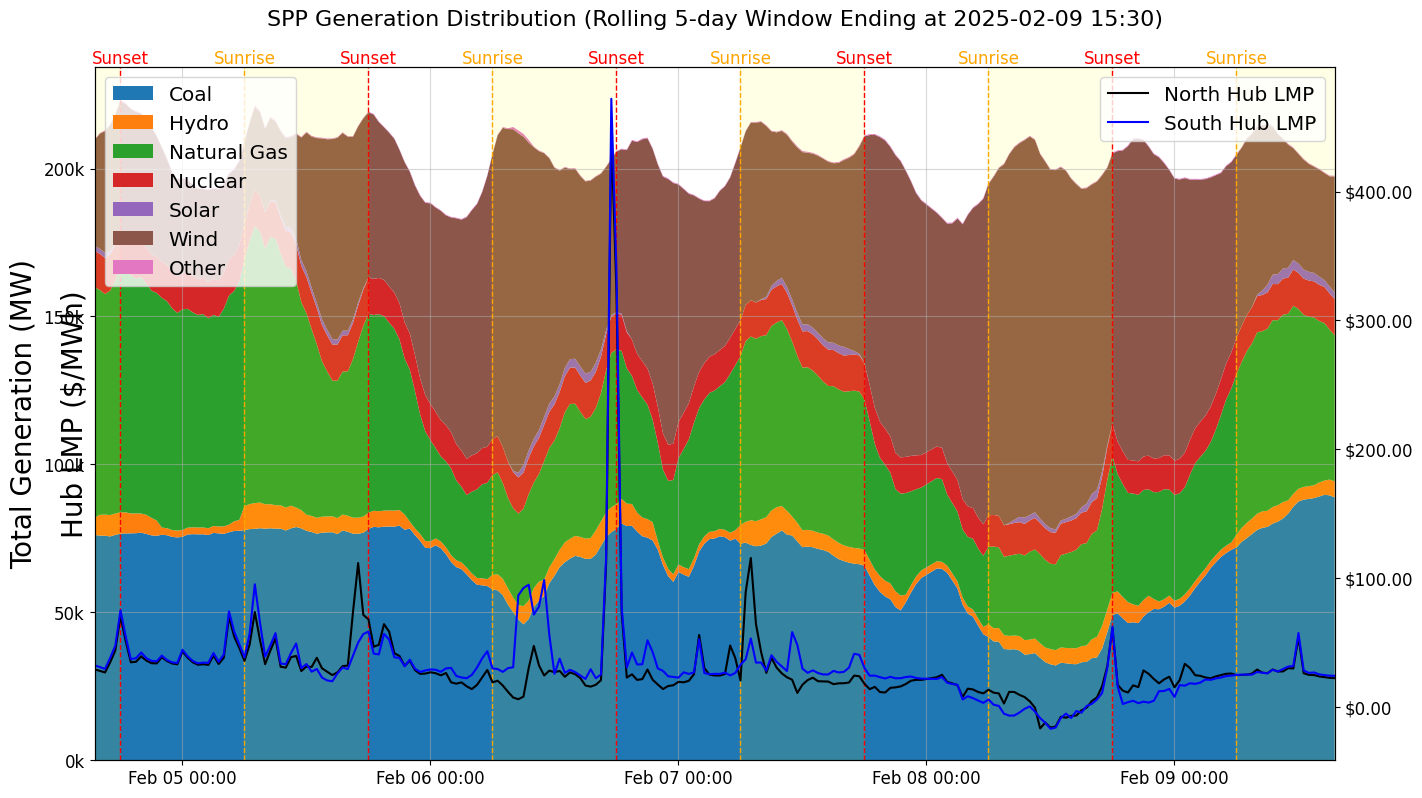

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation

# Variable to control the timeframe for testing
one_day_only = False

if one_day_only:
    data = df_agg.head(48 * 7)
else:
    data = df_agg

# Create a directory to save the images in the TEMP_DIR
output_dir = TEMP_DIR / "output_images"
output_dir.mkdir(exist_ok=True)

# Define the video output path
video_output_path = OUTPUT_DIR / "generation_distribution.mp4"

rolling_window_days = 5

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(16, 9))
ax2 = ax.twinx()  # Create a second y-axis

# Function to update the stacked area chart for each frame
def update(frame):
    ax.clear()
    ax2.clear()
    end_time = data.iloc[frame][time_column]
    start_time = end_time - pd.Timedelta(days=rolling_window_days)
    window_data = data[(data[time_column] >= start_time) & (data[time_column] <= end_time)]
    
    ax.stackplot(
        window_data[time_column],
        [window_data[f"Total Scheduled {source} Generation (MW)"] for source in generation_sources],
        labels=generation_sources
    )
    
    ax2.plot(window_data[time_column], window_data["North Hub LMP"], color="black", label="North Hub LMP")
    ax2.plot(window_data[time_column], window_data["South Hub LMP"], color="blue", label="South Hub LMP")
    
    # Add vertical shaded regions for daylight hours (6:00 to 18:00)
    days = pd.date_range(window_data[time_column].min().date(), window_data[time_column].max().date(), freq='D')
    for day in days:
        day_start = pd.Timestamp.combine(day, pd.Timestamp("06:00").time())
        day_end = pd.Timestamp.combine(day, pd.Timestamp("18:00").time())
        # Only shade the overlapping portion within the frame's time window
        if day_end >= start_time and day_start <= end_time:
            ax.axvspan(max(day_start, start_time), min(day_end, end_time), color="yellow", alpha=0.1)
        
        # Add vertical dashed lines for sunrise and sunset
        if day_start >= start_time and day_start <= end_time:
            ax.axvline(day_start, color="orange", linestyle="--", linewidth=1)
            ax.text(day_start, ax.get_ylim()[1], "Sunrise", color="orange", ha="center", va="bottom", fontsize=12)
        if day_end >= start_time and day_end <= end_time:
            ax.axvline(day_end, color="red", linestyle="--", linewidth=1)
            ax.text(day_end, ax.get_ylim()[1], "Sunset", color="red", ha="center", va="bottom", fontsize=12)
    
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M')
    ax.set_title(f"SPP Generation Distribution (Rolling {rolling_window_days}-day Window Ending at {end_time_str})", pad=30, fontsize=16)
    ax.set_xlim(start_time, end_time)
   
    ax.set_ylabel("Total Generation (MW)", fontsize=20)
    ax.legend(loc="upper left", fontsize="x-large")
    ax.grid(True, alpha=0.5)

    ax2.set_ylabel("Hub LMP ($/MWh)", fontsize=20)
    ax2.legend(loc="upper right", fontsize="x-large")

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1000)}k"))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:.2f}"))

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)


# Create the animation
ani = FuncAnimation(fig, update, frames=len(data), repeat=False)

# Save the animation as a video file
ani.save(video_output_path, writer="ffmpeg", fps=12)

plt.show()